In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
stk_path = "../../data/zz500.csv"
# stk_path = "../../data/GSPC.csv"

test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [2]:
from xgboost import XGBRegressor

def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,close,high,open,low,volume,adj_close,month
2665,2007-01-04,1723.69,1748.091,1738.929,1719.498,3.212987e+09,1723.69,1
2666,2007-01-05,1770.47,1770.483,1719.283,1712.737,2.954547e+09,1770.47,1
1723,2007-01-08,1851.96,1851.964,1773.023,1773.023,3.971932e+09,1851.96,1
1724,2007-01-09,1891.87,1893.723,1855.347,1853.901,4.284591e+09,1891.87,1
2667,2007-01-10,1940.83,1940.832,1896.711,1884.619,4.540634e+09,1940.83,1


Text(0, 0.5, 'USD')

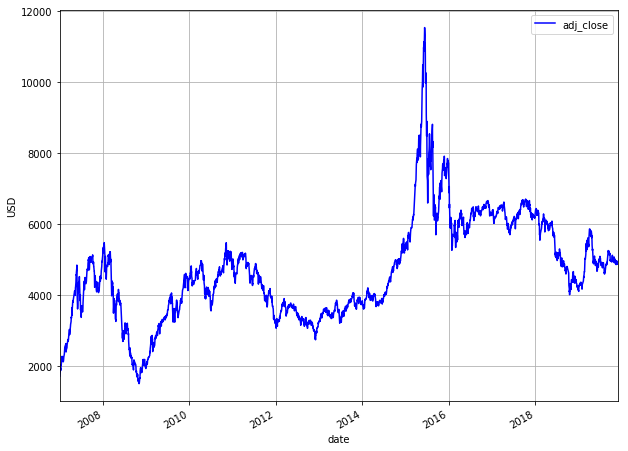

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [5]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,volume,adj_close,month,range_hl,range_oc
2665,2007-01-04,3.212987e+09,1723.69,1,28.593,15.239
2666,2007-01-05,2.954547e+09,1770.47,1,57.746,-51.187
1723,2007-01-08,3.971932e+09,1851.96,1,78.941,-78.937
1724,2007-01-09,4.284591e+09,1891.87,1,39.822,-36.523
2667,2007-01-10,4.540634e+09,1940.83,1,56.213,-44.119


Now we use lags up to N number of days to use as features.

In [6]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [7]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2007-01-09,4.284591e+09,1891.870,1,39.822,-36.523,3,1851.96,78.941,-78.937,3.971932e+09,1770.47,57.746,-51.187,2.954547e+09,1723.69,28.593,15.239,3.212987e+09
4,2007-01-10,4.540634e+09,1940.830,1,56.213,-44.119,4,1891.87,39.822,-36.523,4.284591e+09,1851.96,78.941,-78.937,3.971932e+09,1770.47,57.746,-51.187,2.954547e+09
5,2007-01-11,5.388346e+09,1952.230,1,69.665,-5.729,5,1940.83,56.213,-44.119,4.540634e+09,1891.87,39.822,-36.523,4.284591e+09,1851.96,78.941,-78.937,3.971932e+09
6,2007-01-12,4.408009e+09,1881.750,1,93.275,59.595,6,1952.23,69.665,-5.729,5.388346e+09,1940.83,56.213,-44.119,4.540634e+09,1891.87,39.822,-36.523,4.284591e+09
7,2007-01-15,3.881263e+09,1986.539,1,105.072,-105.072,7,1881.75,93.275,59.595,4.408009e+09,1952.23,69.665,-5.729,5.388346e+09,1940.83,56.213,-44.119,4.540634e+09


In [8]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [9]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [10]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2007-01-09,4.284591e+09,1891.870,1,39.822,-36.523,3,1851.96,78.941,-78.937,...,15.239,3.212987e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-10,4.540634e+09,1940.830,1,56.213,-44.119,4,1891.87,39.822,-36.523,...,-51.187,2.954547e+09,1891.870000,NaN,39.822000,NaN,-36.523000,NaN,4.284591e+09,NaN
5,2007-01-11,5.388346e+09,1952.230,1,69.665,-5.729,5,1940.83,56.213,-44.119,...,-78.937,3.971932e+09,1916.350000,34.619948,48.017500,11.590187,-40.321000,5.371183,4.412612e+09,1.810496e+08
6,2007-01-12,4.408009e+09,1881.750,1,93.275,59.595,6,1952.23,69.665,-5.729,...,-36.523,4.284591e+09,1928.310000,32.068601,55.233333,14.945600,-28.790333,20.329624,4.737857e+09,5.777040e+08
7,2007-01-15,3.881263e+09,1986.539,1,105.072,-105.072,7,1881.75,93.275,59.595,...,-44.119,4.540634e+09,1924.936667,37.832607,73.051000,18.761575,3.249000,52.436646,4.778997e+09,5.318626e+08


# Split into train, dev and test set

In [11]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1878
num_cv = 626
num_test = 626
train.shape = (1878, 27)
cv.shape = (626, 27)
train_cv.shape = (2504, 27)
test.shape = (626, 27)


# Scale the train, dev and test set

In [12]:
cols_to_scale = ["adj_close"]

for i in range(1, N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 3.81976240e+03  3.81815139e+03  8.99206550e+01 -5.79761235e+00
  4.28182906e+09  3.81652228e+03  8.99266486e+01 -5.81075772e+00
  4.27951687e+09  3.81487635e+03  8.99075149e+01 -5.80916613e+00
  4.27631082e+09]
scaler.var_ = [6.51257445e+05 6.52721072e+05 3.19519759e+03 5.54040873e+03
 3.27992428e+18 6.54406002e+05 3.19474441e+03 5.54127736e+03
 3.27601655e+18 6.56204953e+05 3.19640359e+03 5.54133960e+03
 3.26354151e+18]
train_scaled.shape = (1878, 13)
train_scaled.shape = (1878, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-2.388947,-2.433672,-0.194241,-0.982608,-0.171114,-2.529258,-0.569347,-0.609570,-0.732037,-2.581505,-1.084507,0.282753,-0.588601,2007-01-09,1
1,-2.328278,-2.384273,-0.886293,-0.412787,0.001525,-2.428523,-0.194360,-0.982355,-0.169939,-2.523757,-0.568860,-0.609588,-0.731660,2007-01-10,1
2,-2.314152,-2.323672,-0.596320,-0.514838,0.142903,-2.379187,-0.886462,-0.412578,0.002803,-2.423160,-0.193971,-0.982371,-0.168488,2007-01-11,1
3,-2.401487,-2.309561,-0.358342,0.000922,0.610979,-2.318665,-0.596469,-0.514621,0.144265,-2.373892,-0.885893,-0.412598,0.004583,2007-01-12,1
4,-2.271638,-2.396799,0.059342,0.878532,0.069672,-2.304572,-0.358473,0.001098,0.612621,-2.313452,-0.595975,-0.514639,0.146315,2007-01-15,1


In [13]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 4.51835110e+03  4.51661774e+03  1.06909889e+02 -6.53767508e+00
  5.76561587e+09  4.51485818e+03  1.06917805e+02 -6.55152552e+00
  5.76401042e+09  4.51308631e+03  1.06900577e+02 -6.53706226e+00
  5.76271139e+09]
scaler_train_cv.var_ = [2.31018034e+06 2.31189759e+06 8.79333890e+03 9.41134546e+03
 1.34266533e+19 2.31380602e+06 8.79240364e+03 9.41210174e+03
 1.34292228e+19 2.31583268e+06 8.79435887e+03 9.41220805e+03
 1.34316234e+19]
train_cv_scaled.shape = (2504, 13)
train_cv_scaled.shape = (2504, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.728030,-1.752496,-0.298262,-0.746292,-0.489510,-1.804189,-0.524400,-0.460084,-0.766651,-1.832975,-0.835029,0.224457,-0.695711,2007-01-09,1
1,-1.695818,-1.726248,-0.715430,-0.309089,-0.404183,-1.750617,-0.298363,-0.746119,-0.489026,-1.802235,-0.524158,-0.460230,-0.766228,2007-01-10,1
2,-1.688318,-1.694048,-0.540635,-0.387388,-0.334307,-1.724380,-0.715553,-0.308933,-0.403707,-1.748686,-0.298146,-0.746264,-0.488627,2007-01-11,1
3,-1.734688,-1.686551,-0.397182,0.008336,-0.102960,-1.692193,-0.540748,-0.387230,-0.333837,-1.722461,-0.715289,-0.309081,-0.403316,2007-01-12,1
4,-1.665745,-1.732904,-0.145403,0.681695,-0.370502,-1.684698,-0.397288,0.008478,-0.102512,-1.690288,-0.540505,-0.387377,-0.333453,2007-01-15,1


In [14]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1881,2014-09-30,1.123078,-0.329112,-0.793966,-0.957431,-0.080296,1.037727,-0.642938,-0.509177,1.152115,-0.118848,-0.935265,1.054113
1882,2014-10-08,0.964204,0.068110,-1.032314,0.340770,-1.125847,0.785077,-0.560455,-0.594082,1.154537,0.661492,0.488901,-1.150393
1883,2014-10-09,1.091150,-0.218399,-0.872751,1.126999,-0.345772,-0.781227,-1.154699,0.579148,0.575551,1.150992,-0.495414,-0.655578
1884,2014-10-10,0.682966,0.464847,-1.147813,0.423347,0.718694,-1.142041,0.953605,-1.040698,0.087093,1.069010,-0.156466,-0.912544
1885,2014-10-13,-1.017703,0.981303,0.036400,-1.125634,0.339857,0.785777,0.753045,0.381562,-1.134607,-0.114833,1.052459,-0.937626


In [15]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2507,2017-04-28,0.999680,0.000641,-1.000320,1.105941,-0.840497,-0.265444,-1.122471,0.795851,0.326620,1.132518,-0.371189,-0.761329
2508,2017-05-02,1.032500,-0.068525,-0.963975,-0.501453,1.151509,-0.650055,-0.700262,-0.444994,1.145257,-0.694367,1.146177,-0.451810
2509,2017-05-03,0.736641,0.401757,-1.138398,-0.701438,-0.443629,1.145067,1.148891,-0.674628,-0.474263,-0.426458,-0.716072,1.142530
2510,2017-05-04,-1.127004,0.781209,0.345795,0.731839,-1.139424,0.407585,0.941490,0.108217,-1.049707,0.913831,0.154382,-1.068213
2511,2017-05-05,-1.020540,0.042432,0.978109,1.071546,-0.163159,-0.908387,0.340075,0.785609,-1.125685,1.101683,-0.251307,-0.850376


# Split into X and y

In [16]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1878, 12)
y_train.shape = (1878,)
X_cv.shape = (626, 12)
y_cv.shape = (626,)
X_train_cv.shape = (2504, 12)
y_train_cv.shape = (2504,)
X_sample.shape = (626, 12)
y_sample.shape = (626,)


In [17]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1878, 12)
y_train_scaled.shape = (1878,)
X_cv_scaled.shape = (626, 12)
X_train_cv_scaled.shape = (2504, 12)
y_train_cv_scaled.shape = (2504,)
X_sample_scaled.shape = (626, 12)


# EDA

Text(0.5, 1.0, 'Without scaling')

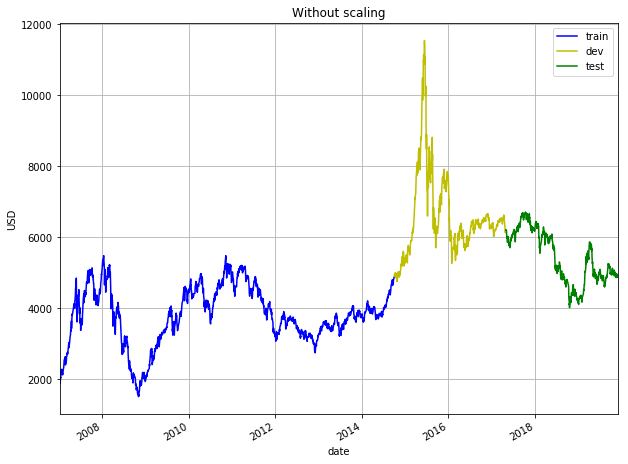

In [18]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

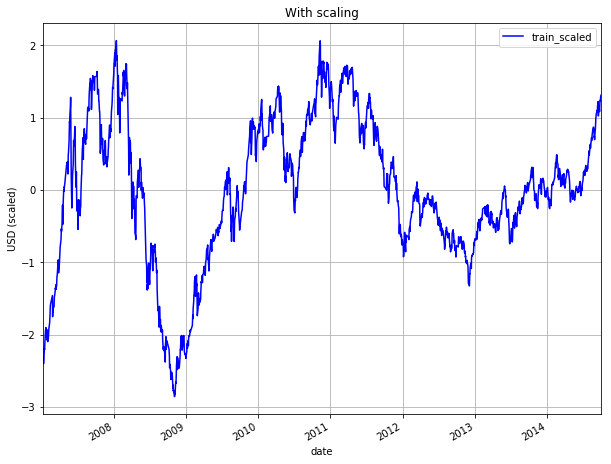

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [20]:
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from src.models.m1_xgb import *
from src.conf.configuration import regress_conf

# load xgboost regression configuration
regress_conf.xgb_config_r()
regress_conf.cv_folds = None
regress_conf.early_stop_round = 1000
regress_conf.max_round = 10000

param = {'base_score':0.5, 
         'booster':'gbtree', 
         'colsample_bylevel':1,
         'colsample_bynode':1, 
         'colsample_bytree':1, 
         'gamma':0,
         'importance_type':'gain',
         'learning_rate':0.1,
         'max_delta_step':0,
         'max_depth':3,
         'min_child_weight':1,
         'missing':None,
         'n_estimators':100,
         'n_jobs':1,
         'nthread':4,
         'objective':'reg:linear',
         'random_state':0,
         'reg_alpha':0,
         'reg_lambda':1,
         'scale_pos_weight':1,
         'seed':100,
         'subsample':1, 
         'verbosity':1
        }
regress_conf.params.update(param)

xgb_m = XGBooster(regress_conf)
best_score, best_round, best_model = xgb_m.fit(X_train_scaled.values, y_train_scaled.values)


2019-12-02 22:01:12,671 - ../../../src/models/m1_xgb.py[line:96] - INFO: NonCrossValidation。。。。


[0]	train-rmse:1.01014	train-logloss:0.204921
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 1000 rounds.
[5]	train-rmse:0.610594	train-logloss:-12.1038
[10]	train-rmse:0.374831	train-logloss:-15.8613
[15]	train-rmse:0.237996	train-logloss:-16.3528
[20]	train-rmse:0.161649	train-logloss:-16.522
[25]	train-rmse:0.122344	train-logloss:-16.5391
[30]	train-rmse:0.103836	train-logloss:-16.5607
[35]	train-rmse:0.095414	train-logloss:-16.5628
[40]	train-rmse:0.090983	train-logloss:-16.5853
[45]	train-rmse:0.08832	train-logloss:-16.5914
[50]	train-rmse:0.086441	train-logloss:-16.5916
[55]	train-rmse:0.084968	train-logloss:-16.5949
[60]	train-rmse:0.083487	train-logloss:-16.5996
[65]	train-rmse:0.082653	train-logloss:-16.6022
[70]	train-rmse:0.08188	train-logloss:-16.6034
[75]	train-rmse:0.081089	train-logloss:-16.6037
[80]	train-rmse:0.080501	train-logloss:-16.6097
[85]	train-rmse:0.079805	train-loglos

[830]	train-rmse:0.035756	train-logloss:-16.6664
[835]	train-rmse:0.035554	train-logloss:-16.6664
[840]	train-rmse:0.035472	train-logloss:-16.6664
[845]	train-rmse:0.035328	train-logloss:-16.6665
[850]	train-rmse:0.035087	train-logloss:-16.6668
[855]	train-rmse:0.03491	train-logloss:-16.6669
[860]	train-rmse:0.034709	train-logloss:-16.6669
[865]	train-rmse:0.034512	train-logloss:-16.667
[870]	train-rmse:0.034382	train-logloss:-16.667
[875]	train-rmse:0.034245	train-logloss:-16.667
[880]	train-rmse:0.034057	train-logloss:-16.6688
[885]	train-rmse:0.033966	train-logloss:-16.6688
[890]	train-rmse:0.033851	train-logloss:-16.6705
[895]	train-rmse:0.033739	train-logloss:-16.6705
[900]	train-rmse:0.033558	train-logloss:-16.6706
[905]	train-rmse:0.033381	train-logloss:-16.6706
[910]	train-rmse:0.033242	train-logloss:-16.6707
[915]	train-rmse:0.033098	train-logloss:-16.6712
[920]	train-rmse:0.032939	train-logloss:-16.6713
[925]	train-rmse:0.032754	train-logloss:-16.6713
[930]	train-rmse:0.03262

[1660]	train-rmse:0.017002	train-logloss:-16.6867
[1665]	train-rmse:0.016908	train-logloss:-16.6867
[1670]	train-rmse:0.016848	train-logloss:-16.6867
[1675]	train-rmse:0.016792	train-logloss:-16.6867
[1680]	train-rmse:0.016689	train-logloss:-16.6867
[1685]	train-rmse:0.016629	train-logloss:-16.6875
[1690]	train-rmse:0.01656	train-logloss:-16.6875
[1695]	train-rmse:0.016492	train-logloss:-16.6875
[1700]	train-rmse:0.016434	train-logloss:-16.6876
[1705]	train-rmse:0.016361	train-logloss:-16.6876
[1710]	train-rmse:0.01629	train-logloss:-16.6876
[1715]	train-rmse:0.01621	train-logloss:-16.6876
[1720]	train-rmse:0.016151	train-logloss:-16.6876
[1725]	train-rmse:0.016067	train-logloss:-16.6876
[1730]	train-rmse:0.016009	train-logloss:-16.6876
[1735]	train-rmse:0.015948	train-logloss:-16.6876
[1740]	train-rmse:0.015888	train-logloss:-16.6876
[1745]	train-rmse:0.015815	train-logloss:-16.6876
[1750]	train-rmse:0.015746	train-logloss:-16.6876
[1755]	train-rmse:0.015699	train-logloss:-16.6876
[17

[2485]	train-rmse:0.009054	train-logloss:-16.6899
[2490]	train-rmse:0.009016	train-logloss:-16.6899
[2495]	train-rmse:0.008982	train-logloss:-16.6899
[2500]	train-rmse:0.008958	train-logloss:-16.6899
[2505]	train-rmse:0.008923	train-logloss:-16.6899
[2510]	train-rmse:0.008892	train-logloss:-16.6899
[2515]	train-rmse:0.008841	train-logloss:-16.6899
[2520]	train-rmse:0.00879	train-logloss:-16.6899
[2525]	train-rmse:0.008743	train-logloss:-16.6899
[2530]	train-rmse:0.008711	train-logloss:-16.6899
[2535]	train-rmse:0.008684	train-logloss:-16.6899
[2540]	train-rmse:0.008655	train-logloss:-16.6899
[2545]	train-rmse:0.008617	train-logloss:-16.6899
[2550]	train-rmse:0.008578	train-logloss:-16.6899
[2555]	train-rmse:0.008541	train-logloss:-16.6899
[2560]	train-rmse:0.008508	train-logloss:-16.6899
[2565]	train-rmse:0.008474	train-logloss:-16.6899
[2570]	train-rmse:0.008457	train-logloss:-16.6899
[2575]	train-rmse:0.008429	train-logloss:-16.6899
[2580]	train-rmse:0.008392	train-logloss:-16.6899
[

[3315]	train-rmse:0.004856	train-logloss:-16.6908
[3320]	train-rmse:0.00484	train-logloss:-16.6908
[3325]	train-rmse:0.004818	train-logloss:-16.6908
[3330]	train-rmse:0.004804	train-logloss:-16.6908
[3335]	train-rmse:0.004788	train-logloss:-16.6908
[3340]	train-rmse:0.004777	train-logloss:-16.6909
[3345]	train-rmse:0.004764	train-logloss:-16.6909
[3350]	train-rmse:0.004749	train-logloss:-16.691
[3355]	train-rmse:0.004726	train-logloss:-16.691
[3360]	train-rmse:0.004711	train-logloss:-16.691
[3365]	train-rmse:0.00469	train-logloss:-16.6911
[3370]	train-rmse:0.004679	train-logloss:-16.6911
[3375]	train-rmse:0.004664	train-logloss:-16.6911
[3380]	train-rmse:0.00465	train-logloss:-16.6911
[3385]	train-rmse:0.004631	train-logloss:-16.6911
[3390]	train-rmse:0.004611	train-logloss:-16.6911
[3395]	train-rmse:0.004595	train-logloss:-16.6911
[3400]	train-rmse:0.004576	train-logloss:-16.6911
[3405]	train-rmse:0.00456	train-logloss:-16.6911
[3410]	train-rmse:0.004546	train-logloss:-16.6911
[3415]	

[4140]	train-rmse:0.002707	train-logloss:-16.6915
[4145]	train-rmse:0.0027	train-logloss:-16.6915
[4150]	train-rmse:0.002687	train-logloss:-16.6915
[4155]	train-rmse:0.002683	train-logloss:-16.6915
[4160]	train-rmse:0.002674	train-logloss:-16.6915
[4165]	train-rmse:0.002663	train-logloss:-16.6915
[4170]	train-rmse:0.002657	train-logloss:-16.6915
[4175]	train-rmse:0.002649	train-logloss:-16.6915
[4180]	train-rmse:0.002642	train-logloss:-16.6915
[4185]	train-rmse:0.002632	train-logloss:-16.6915
[4190]	train-rmse:0.002622	train-logloss:-16.6915
[4195]	train-rmse:0.002613	train-logloss:-16.6915
[4200]	train-rmse:0.002604	train-logloss:-16.6915
[4205]	train-rmse:0.002595	train-logloss:-16.6915
[4210]	train-rmse:0.002583	train-logloss:-16.6915
[4215]	train-rmse:0.002574	train-logloss:-16.6915
[4220]	train-rmse:0.002565	train-logloss:-16.6915
[4225]	train-rmse:0.002558	train-logloss:-16.6915
[4230]	train-rmse:0.002551	train-logloss:-16.6915
[4235]	train-rmse:0.002541	train-logloss:-16.6915
[4

[4975]	train-rmse:0.00229	train-logloss:-16.6915
[4980]	train-rmse:0.00229	train-logloss:-16.6915
[4985]	train-rmse:0.00229	train-logloss:-16.6915
[4990]	train-rmse:0.00229	train-logloss:-16.6915
[4995]	train-rmse:0.00229	train-logloss:-16.6915
[5000]	train-rmse:0.00229	train-logloss:-16.6915
[5005]	train-rmse:0.00229	train-logloss:-16.6915
[5010]	train-rmse:0.00229	train-logloss:-16.6915
[5015]	train-rmse:0.00229	train-logloss:-16.6915
[5020]	train-rmse:0.00229	train-logloss:-16.6915
[5025]	train-rmse:0.00229	train-logloss:-16.6915
[5030]	train-rmse:0.00229	train-logloss:-16.6915
[5035]	train-rmse:0.00229	train-logloss:-16.6915
[5040]	train-rmse:0.00229	train-logloss:-16.6915
[5045]	train-rmse:0.00229	train-logloss:-16.6915
[5050]	train-rmse:0.00229	train-logloss:-16.6915
[5055]	train-rmse:0.00229	train-logloss:-16.6915
[5060]	train-rmse:0.00229	train-logloss:-16.6915
[5065]	train-rmse:0.00229	train-logloss:-16.6915
[5070]	train-rmse:0.00229	train-logloss:-16.6915
[5075]	train-rmse:0.

In [21]:
# Do prediction on train set
est_scaled = xgb_m.predict(best_model ,X_train_scaled.values)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 1.848
MAPE on train set = 0.036%


In [22]:
# # Create the model
# from xgboost import XGBRegressor

# model = XGBRegressor(seed=model_seed,
#                      n_estimators=n_estimators,
#                      max_depth=max_depth,
#                      learning_rate=learning_rate,
#                      min_child_weight=min_child_weight,
#                      subsample=subsample,
#                      colsample_bytree=colsample_bytree,
#                      colsample_bylevel=colsample_bylevel,
#                      gamma=gamma)

# # Train the regressor
# model.fit(X_train_scaled, y_train_scaled)


# Predict on train set

In [23]:
# # Do prediction on train set
# est_scaled = model.predict(X_train_scaled)
# est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# # Calculate RMSE
# print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# # Calculate MAPE
# print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

Text(0.5, 1.0, 'Without scaling')

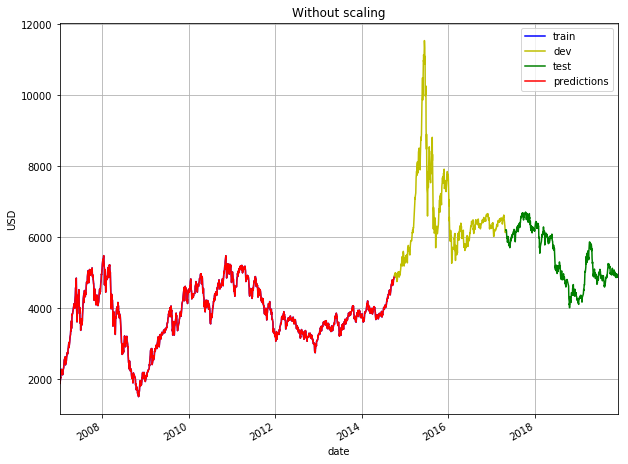

In [24]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [25]:
# Do prediction on test set
est_scaled = xgb_m.predict(best_model, X_cv_scaled.values)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 161.518
MAPE on dev set = 1.494%


/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'USD')

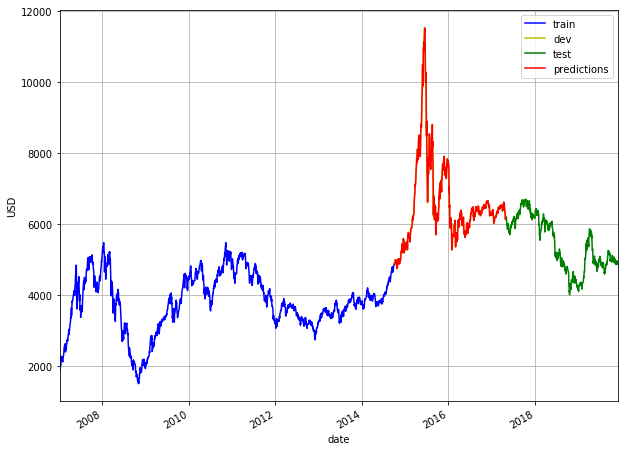

In [26]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

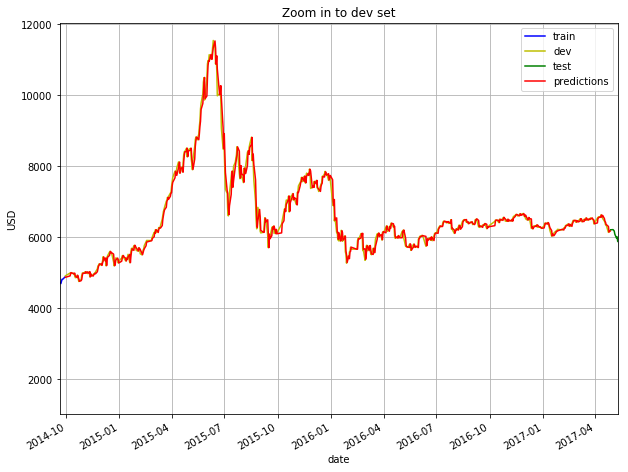

In [27]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
# ax.set_xlim([date(2018, 4, 20), date(2019, 2, 20)])

ax.set_xlim([date(2014, 9, 20), date(2017, 5, 10)])
ax.set_title("Zoom in to dev set")

The predictions capture the turn in directions with a slight lag

Importance features dominated by adj_close and volume

# Final model

In [28]:
# load xgboost regression configuration
regress_conf.xgb_config_r()
regress_conf.cv_folds = None
regress_conf.early_stop_round = 1000
regress_conf.max_round = 10000

param = {'base_score':0.5, 
         'booster':'gbtree', 
         'colsample_bylevel':1,
         'colsample_bynode':1, 
         'colsample_bytree':1, 
         'gamma':0,
         'importance_type':'gain',
         'learning_rate':0.1,
         'max_delta_step':0,
         'max_depth':3,
         'min_child_weight':1,
         'missing':None,
         'n_estimators':100,
         'n_jobs':1,
         'nthread':4,
         'objective':'reg:linear',
         'random_state':0,
         'reg_alpha':0,
         'reg_lambda':1,
         'scale_pos_weight':1,
         'seed':100,
         'subsample':1, 
         'verbosity':1
        }
regress_conf.params.update(param)

xgb_m = XGBooster(regress_conf)
best_score, best_round, best_model = xgb_m.fit(X_train_cv_scaled.values, y_train_cv_scaled.values )

2019-12-02 22:01:17,051 - ../../../src/models/m1_xgb.py[line:96] - INFO: NonCrossValidation。。。。


[0]	train-rmse:1.01013	train-logloss:0.21207
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 1000 rounds.
[5]	train-rmse:0.610166	train-logloss:-13.8666
[10]	train-rmse:0.371764	train-logloss:-17.7804
[15]	train-rmse:0.230822	train-logloss:-18.1255
[20]	train-rmse:0.148704	train-logloss:-18.2432
[25]	train-rmse:0.103149	train-logloss:-18.2612
[30]	train-rmse:0.079679	train-logloss:-18.2648
[35]	train-rmse:0.068327	train-logloss:-18.275
[40]	train-rmse:0.062724	train-logloss:-18.2727
[45]	train-rmse:0.059681	train-logloss:-18.2759
[50]	train-rmse:0.057797	train-logloss:-18.2718
[55]	train-rmse:0.056512	train-logloss:-18.273
[60]	train-rmse:0.055599	train-logloss:-18.2738
[65]	train-rmse:0.054949	train-logloss:-18.2749
[70]	train-rmse:0.054403	train-logloss:-18.2773
[75]	train-rmse:0.053846	train-logloss:-18.2802
[80]	train-rmse:0.053327	train-logloss:-18.2798
[85]	train-rmse:0.052734	train-loglos

[830]	train-rmse:0.025578	train-logloss:-18.3168
[835]	train-rmse:0.025485	train-logloss:-18.3168
[840]	train-rmse:0.02537	train-logloss:-18.3169
[845]	train-rmse:0.025261	train-logloss:-18.3172
[850]	train-rmse:0.025149	train-logloss:-18.3172
[855]	train-rmse:0.025087	train-logloss:-18.3169
[860]	train-rmse:0.024998	train-logloss:-18.3169
[865]	train-rmse:0.02494	train-logloss:-18.317
[870]	train-rmse:0.024875	train-logloss:-18.317
[875]	train-rmse:0.024771	train-logloss:-18.3171
[880]	train-rmse:0.024712	train-logloss:-18.3171
[885]	train-rmse:0.024617	train-logloss:-18.3171
[890]	train-rmse:0.024471	train-logloss:-18.3171
[895]	train-rmse:0.02439	train-logloss:-18.3171
[900]	train-rmse:0.024325	train-logloss:-18.3174
[905]	train-rmse:0.024203	train-logloss:-18.3174
[910]	train-rmse:0.024111	train-logloss:-18.3174
[915]	train-rmse:0.023991	train-logloss:-18.3178
[920]	train-rmse:0.023922	train-logloss:-18.3175
[925]	train-rmse:0.023816	train-logloss:-18.3178
[930]	train-rmse:0.023712

[1660]	train-rmse:0.014359	train-logloss:-18.3197
[1665]	train-rmse:0.014316	train-logloss:-18.3197
[1670]	train-rmse:0.014271	train-logloss:-18.3198
[1675]	train-rmse:0.014226	train-logloss:-18.3197
[1680]	train-rmse:0.014192	train-logloss:-18.3197
[1685]	train-rmse:0.014155	train-logloss:-18.3197
[1690]	train-rmse:0.014102	train-logloss:-18.3197
[1695]	train-rmse:0.014055	train-logloss:-18.3197
[1700]	train-rmse:0.014019	train-logloss:-18.3197
[1705]	train-rmse:0.013957	train-logloss:-18.3197
[1710]	train-rmse:0.013938	train-logloss:-18.3197
[1715]	train-rmse:0.01389	train-logloss:-18.3197
[1720]	train-rmse:0.013856	train-logloss:-18.3197
[1725]	train-rmse:0.013796	train-logloss:-18.3197
[1730]	train-rmse:0.013732	train-logloss:-18.3202
[1735]	train-rmse:0.013681	train-logloss:-18.3202
[1740]	train-rmse:0.013663	train-logloss:-18.3202
[1745]	train-rmse:0.013624	train-logloss:-18.3203
[1750]	train-rmse:0.013555	train-logloss:-18.3203
[1755]	train-rmse:0.013533	train-logloss:-18.3203
[

[2485]	train-rmse:0.008731	train-logloss:-18.3216
[2490]	train-rmse:0.008714	train-logloss:-18.3216
[2495]	train-rmse:0.008689	train-logloss:-18.3216
[2500]	train-rmse:0.008665	train-logloss:-18.3216
[2505]	train-rmse:0.008636	train-logloss:-18.3216
[2510]	train-rmse:0.008601	train-logloss:-18.3216
[2515]	train-rmse:0.008582	train-logloss:-18.3216
[2520]	train-rmse:0.008557	train-logloss:-18.3216
[2525]	train-rmse:0.00853	train-logloss:-18.3216
[2530]	train-rmse:0.008506	train-logloss:-18.3216
[2535]	train-rmse:0.008473	train-logloss:-18.3216
[2540]	train-rmse:0.008435	train-logloss:-18.3216
[2545]	train-rmse:0.008397	train-logloss:-18.3216
[2550]	train-rmse:0.008368	train-logloss:-18.3216
[2555]	train-rmse:0.008332	train-logloss:-18.3216
[2560]	train-rmse:0.008296	train-logloss:-18.3216
[2565]	train-rmse:0.00828	train-logloss:-18.3216
[2570]	train-rmse:0.008259	train-logloss:-18.3215
[2575]	train-rmse:0.008234	train-logloss:-18.3215
[2580]	train-rmse:0.008202	train-logloss:-18.3215
[2

[3315]	train-rmse:0.005279	train-logloss:-18.3223
[3320]	train-rmse:0.005259	train-logloss:-18.3223
[3325]	train-rmse:0.005245	train-logloss:-18.3223
[3330]	train-rmse:0.005224	train-logloss:-18.3224
[3335]	train-rmse:0.005213	train-logloss:-18.3224
[3340]	train-rmse:0.005202	train-logloss:-18.3224
[3345]	train-rmse:0.005195	train-logloss:-18.3224
[3350]	train-rmse:0.005183	train-logloss:-18.3224
[3355]	train-rmse:0.005165	train-logloss:-18.3224
[3360]	train-rmse:0.00515	train-logloss:-18.3224
[3365]	train-rmse:0.005136	train-logloss:-18.3224
[3370]	train-rmse:0.005122	train-logloss:-18.3224
[3375]	train-rmse:0.005106	train-logloss:-18.3224
[3380]	train-rmse:0.005086	train-logloss:-18.3224
[3385]	train-rmse:0.005071	train-logloss:-18.3224
[3390]	train-rmse:0.005059	train-logloss:-18.3224
[3395]	train-rmse:0.005046	train-logloss:-18.3224
[3400]	train-rmse:0.005031	train-logloss:-18.3224
[3405]	train-rmse:0.005023	train-logloss:-18.3224
[3410]	train-rmse:0.005009	train-logloss:-18.3224
[

[4140]	train-rmse:0.003299	train-logloss:-18.3225
[4145]	train-rmse:0.003292	train-logloss:-18.3225
[4150]	train-rmse:0.003284	train-logloss:-18.3225
[4155]	train-rmse:0.003273	train-logloss:-18.3225
[4160]	train-rmse:0.003265	train-logloss:-18.3225
[4165]	train-rmse:0.003256	train-logloss:-18.3225
[4170]	train-rmse:0.00325	train-logloss:-18.3225
[4175]	train-rmse:0.003245	train-logloss:-18.3225
[4180]	train-rmse:0.003242	train-logloss:-18.3225
[4185]	train-rmse:0.003232	train-logloss:-18.3225
[4190]	train-rmse:0.00322	train-logloss:-18.3225
[4195]	train-rmse:0.003213	train-logloss:-18.3225
[4200]	train-rmse:0.003204	train-logloss:-18.3225
[4205]	train-rmse:0.003198	train-logloss:-18.3225
[4210]	train-rmse:0.00319	train-logloss:-18.3225
[4215]	train-rmse:0.003182	train-logloss:-18.3225
[4220]	train-rmse:0.003171	train-logloss:-18.3225
[4225]	train-rmse:0.003164	train-logloss:-18.3225
[4230]	train-rmse:0.003155	train-logloss:-18.3225
[4235]	train-rmse:0.003151	train-logloss:-18.3225
[42

[4965]	train-rmse:0.002421	train-logloss:-18.3226
[4970]	train-rmse:0.002421	train-logloss:-18.3226
[4975]	train-rmse:0.002421	train-logloss:-18.3226
[4980]	train-rmse:0.002421	train-logloss:-18.3226
[4985]	train-rmse:0.002421	train-logloss:-18.3226
[4990]	train-rmse:0.002421	train-logloss:-18.3226
[4995]	train-rmse:0.002421	train-logloss:-18.3226
[5000]	train-rmse:0.002421	train-logloss:-18.3226
[5005]	train-rmse:0.002421	train-logloss:-18.3226
[5010]	train-rmse:0.002421	train-logloss:-18.3226
[5015]	train-rmse:0.002421	train-logloss:-18.3226
[5020]	train-rmse:0.002421	train-logloss:-18.3226
[5025]	train-rmse:0.002421	train-logloss:-18.3226
[5030]	train-rmse:0.002421	train-logloss:-18.3226
[5035]	train-rmse:0.002421	train-logloss:-18.3226
[5040]	train-rmse:0.002421	train-logloss:-18.3226
[5045]	train-rmse:0.002421	train-logloss:-18.3226
[5050]	train-rmse:0.002421	train-logloss:-18.3226
[5055]	train-rmse:0.002421	train-logloss:-18.3226
[5060]	train-rmse:0.002421	train-logloss:-18.3226


In [29]:
# Do prediction on train set
est_scaled = xgb_m.predict(best_model ,X_train_cv_scaled.values)
est = est_scaled * math.sqrt(scaler_train_cv.var_[0]) + scaler_train_cv.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train_cv, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train_cv, est))

RMSE on train set = 3.680
MAPE on train set = 0.066%


Text(0.5, 1.0, 'Without scaling')

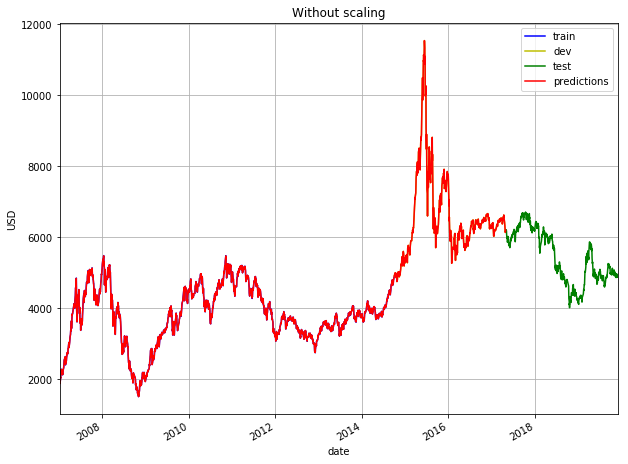

In [30]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train_cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [31]:
# Do prediction on test set
est_scaled = xgb_m.predict(best_model, X_sample_scaled.values)
test['est_scaled'] = est_scaled
test['est'] = test['est_scaled'] * test['adj_close_std'] + test['adj_close_mean']

# Calculate RMSE
mean_bef_tuning = math.mean(y_sample)
print("mean on test set = %0.3f" % rmse_bef_tuning)


rmse_bef_tuning = math.sqrt(mean_squared_error(y_sample, test['est']))
print("RMSE on test set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on test set = %0.3f%%" % mape_bef_tuning)

RMSE on test set = 74.554
MAPE on test set = 1.494%


/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'USD')

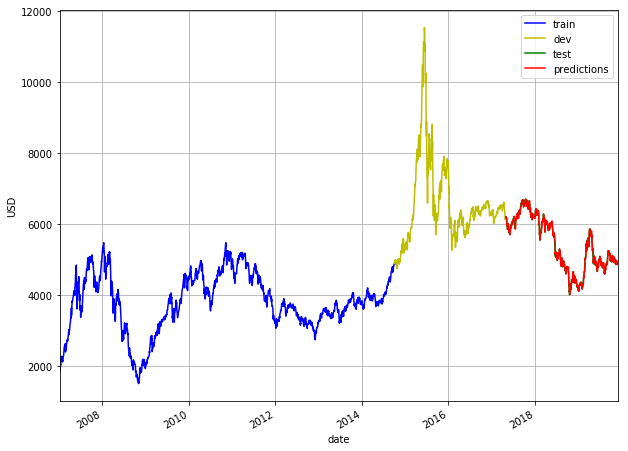

In [32]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': test['est'], 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

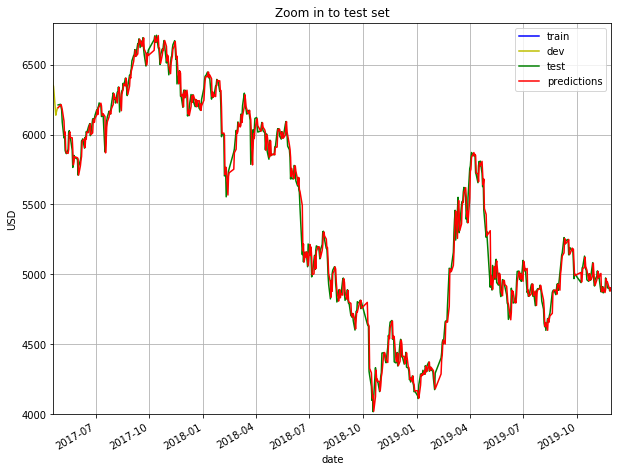

In [33]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 4, 20), date(2019, 11, 29)])
ax.set_ylim([4000, 6800])
ax.set_title("Zoom in to test set")

Similar to dev set, the predictions capture turns in direction with a slight lag

(3944, 6730)

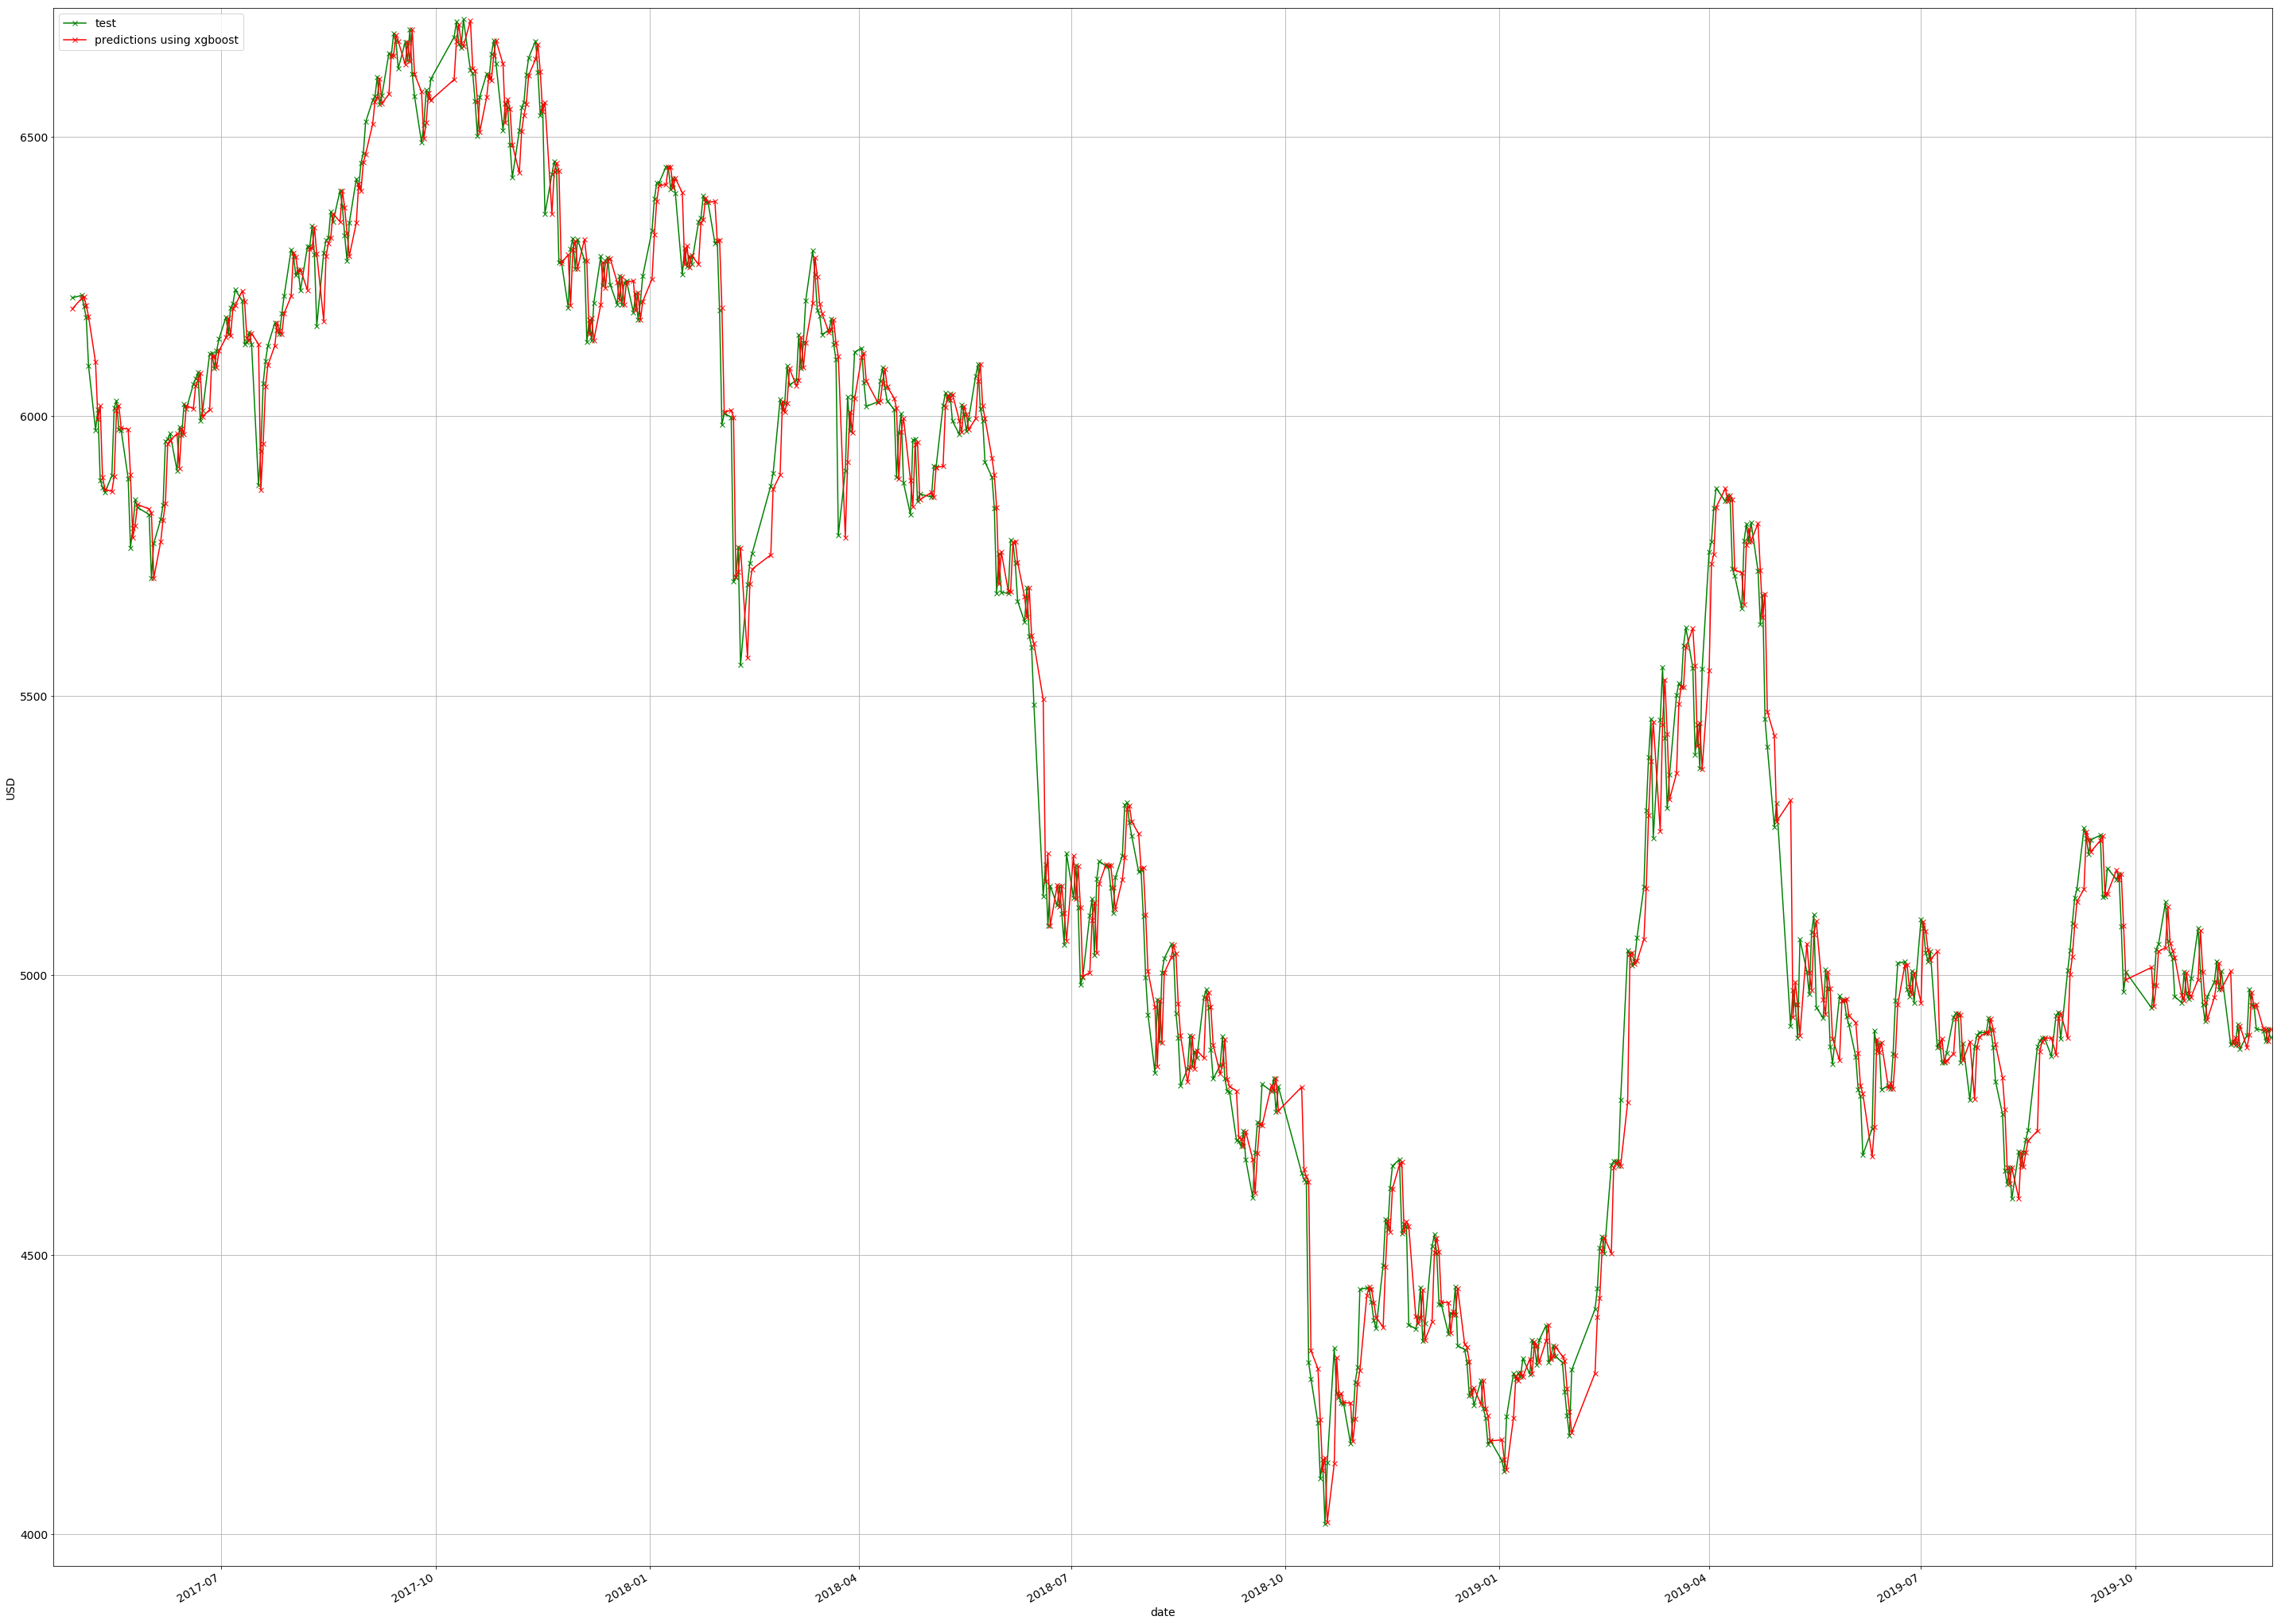

In [34]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 50, 40 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 4, 20), date(2019, 11, 29)])
ax.set_ylim([3944, 6730])

In [35]:
# # Save as csv
# test_xgboost = est_df
# test_xgboost.to_csv("./out/test_xgboost.csv")

# Findings
* By scaling the features properly, we can get good results for our predictions
* RMSE and MAPE changed very little with hyperparameter tuning
* The final RMSE and MAPE for test set are 1.162 and 0.58% respectively